# Модули

In [116]:
import os
import math
import xlwt
import xlrd
import glob
import datetime
import openpyxl
import xlsxwriter

from lmfit import Model
from struct import unpack
from collections import deque
from copy import copy, deepcopy
from openpyxl import load_workbook
from datetime import datetime, date, time
from lmfit.models import GaussianModel, PowerLawModel, LognormalModel


import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from numpy import random, mean, var, std, median,arange
from IPython import get_ipython
from matplotlib import mlab
import matplotlib.ticker as ticker

from astropy.utils import iers
from astropy.time import Time, TimeDelta
from astropy.coordinates import Angle
from astropy import units as u
from bisect import bisect_left
from scipy import signal, misc, linalg as lng

plt.rcParams.update({'figure.max_open_warning': 0})
iers.conf.auto_download = False
import matplotlib
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
matplotlib.use('nbagg')

# Ввод параметров

In [117]:
path_name = str('some_frb')
name_source = path_name
data_process = str('')
data_lenth = 'short'
reg = 'N1'

try:
    path = '/home/elinxt/work/' + path_name + '/'
    os.mkdir(path)
    
except Exception as e: 
    
    print('Такая папка уже существует.')

alfa = [5,34,0]
delta = [41,42,0]

DM = 247
DM = DM*10**-3


#8.10.2015 0521 + 33.1 570 ± 5 6.2 1.4 3500 0.275 0.273

# B0525+21  sr68       05:28:52.264         9  ywml10     +22:00:04            2  ywml10     3.74553925030            3  ywml10     50.8695       13  bkk+16 
# B0523+11      mlt+78     05:25:56.4483       11  hlk+04     +11:15:19.08         7  hlk+04     0.35443759451370        13  hlk+04     79.418 
# J0519+44      hrk+08     05:19                0  hrk+08     0.515                    0  hrk+08     52             0  hrk+08 

Такая папка уже существует.


# Звездное время

In [118]:
def star_time(time, delta):
    t1900 = Time('1900-01-01T12:00:00', format='isot', precision=7)
    utd = (time.jd - t1900.jd + 1)
    utd2 = utd - 36525
    utcen = utd2 / 36525
    ts0 = 6 * 3600 + 41 * 60 + 50.54841 + 8640184.812866 * utcen + 0.093104 * utcen * utcen - 6.2e-6 * utcen * utcen * utcen
    td0 = ts0 / 86400
    td0 = td0 + ((time.datetime.hour + time.datetime.minute / 60 +
                  time.datetime.second / 3600) / 24) * 1.002737909
    
    td0 = td0 - int(td0)
    if td0 < 0:
        td0 += 1
    tdh = td0 * 24
    return tdh

def culmination_utc_to_sideral(time):
    a = (str(time)[0:11] + '00:00:00.0000000')
    time2 = Time(a, format='isot', precision=7)
    
    #time2 = Time('2018-08-25T00:00:00.000', format='isot', precision=7)
    s0 = star_time(time2, delta)
    hour = time.datetime.hour + time.datetime.minute/60 + time.datetime.second/3600
    s_hour = hour / (1 - 236.55/(24*3600))#;    // столько звездных часов прошло с начала дня до кульминации
    if (s_hour < 0):
        s_hour = s_hour + 24.
    s_culm = s0 + s_hour
    if ( s_culm > 24.):
        s_culm = s_culm - 24.
    return s_culm

def add_lambda_bsa1(s_culm):
    lambda_grad = (37 + 37 / 60 + 48 / 3600) / 360
    lambda_hour = lambda_grad * 24
    s_culm1 = s_culm + lambda_hour
    if (s_culm1 < 0):
        s_culm1 = s_culm1 + 24
    return s_culm1

def add_incline_bsa1(alfa, delta):
    fi = 0.956829
    be = 0.008436
    rg = 1.7453292e-2
    rm = 2.90888e-4
    rs = 4.8481368e-6
    am = 46.1*rs
    an = 20.0*rs
    alfa = (alfa[0] * rg + alfa[1] * rm + alfa[2] * rs) * 15
    delta = (delta[0] * rg + delta[1] * rm + delta[2] * rs)
    
    aa = (((np.sin(fi))**2) * ((np.cos(be))**2) + ((np.cos(fi))**2))
    bb = 2 * (np.sin(fi)) * (np.cos(be)) * np.sin(delta)
    cc = (np.sin(delta))**2 - (np.cos(fi))**2

    x = (bb + ((bb)**2 - 4. * aa * cc)**0.5) / (2 * aa)
    y = x * np.sin(be) / np.cos(delta)
    z = (1. - (y * y))**0.5

    t = y / z
    dalfa = np.arctan(t)
    alfa = alfa + dalfa

    if alfa < 0:
        alfa = alfa + 2 * np.pi

    RG = (np.pi / 180.)
    RM = (np.pi / 180.) / 60.
    RS = (np.pi / 180.) / 3600.
    hour = int(alfa / (RG * 15))
    mint = int((alfa - (hour * RG * 15.)) / (RM * 15.))
    sec = (alfa - hour * RG * 15. - mint * RM * 15.) / (RS * 15.)
    hour = hour + mint / 60. + sec / 3600;
    while (hour >= 24):
        hour = hour - 24
    return hour

def precess1(coord, time, delta):
    RG = (np.pi / 180.)
    RM = (np.pi / 180.) / 60.
    RS = (np.pi / 180.) / 3600.
    am = 46.1 * RS
    an = 20.4 * RS
    alfa = (int(coord[0]) + int(coord[1]) / 60 + coord[2] / 3600) * 15 * np.pi / 180
    delta = (int(delta[0]) + int(delta[1]) / 60 +
             delta[2] / 3600) * np.pi / 180
    
    t2000 = Time('2000-01-01T12:00:00')
    t = (time.jd - t2000.jd)/365
    alfa1 = alfa
    delta1 = delta

    for i in range(2):
        alf = alfa - (am + an * np.sin(alfa1) * np.tan(delta1)) * t
        del1 = delta - (an * np.cos(alfa1)) * t
        alfa1 = (alf + alfa) / 2
        delta1 = (del1 + delta) / 2
        
    hour = int(alf / (RG * 15))
    mint = int((alf - (hour * RG * 15.)) / (RM * 15))
    sec = (alf - hour * RG * 15 - mint * RM * 15) / (RS * 15)
    
    while (hour >= 24):
        hour = hour - 24
        
    alfa2 = [hour, mint, sec]
    grad0 = del1 * 180. / np.pi
    igrad = int(grad0)
    min0  = (grad0 - igrad)*60
    imin  = int((grad0 - igrad)*60)
    sec = (min0 - imin)*60
    delta = [igrad, imin, sec]

    if hour >= 24:
        hour = hour - 24
    
    alfa2 = hour +  mint/60 +  sec/3600
    return alfa2, delta

def my_sidereal_time(time, delta):
    s_culm = culmination_utc_to_sideral(time)
    s_culm = add_lambda_bsa1(s_culm)
    alfa = [0, 0, 0]
    alfa[0] = int(s_culm)
    alfa[1] = int((s_culm - int(s_culm)) * 60)
    a = (s_culm - int(s_culm)) * 60
    alfa[2] = (a - int(a)) * 60
    s_culm = add_incline_bsa1(alfa, delta)
    mint = int((s_culm - int(s_culm)) * 60)
    a = (s_culm - int(s_culm)) * 60
    sec = (a - int(a)) * 60
    ihour = int(s_culm)
    imin = int(mint)
    day = 0
    while (ihour >= 24):
        ihour = ihour - 24
        day += 1
    coord = [ihour, imin, sec]
    alfa2, delta = precess1(coord, time, delta)
    return alfa2

# Список файлов и открытие 

In [135]:
def read_head_pntr(filename):
    head = {}
    with open(filename, 'rb') as F:
        for i in range(16):
            line = F.readline()
            a, *b = line.decode("utf-8").strip('\n').split()
            head[a] = b
    return head


def time_begin_and_end(head):

    if 'UTC' in head['date_begin']:
        # begin
        day, month, year = head['date_begin'][2].split('.')
        hour, minute, second = head['time_begin'][2].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_start = Time(isot_time,
                          format='isot',
                          location=('37.63d', '54.8394444444d'),
                          precision=3)

        # time_start -= 4*u.hour #ПРОВЕРИТЬ

        # end
        day, month, year = head['date_end'][0].split('.')
        hour, minute, second = head['time_end'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_end = Time(isot_time,
                        format='isot',
                        location=('37.63d', '54.8394444444d'),
                        precision=3)

        time_end -= 4 * u.hour
    else:
        # begin
        day, month, year = head['date_begin'][0].split('.')
        hour, minute, second = head['time_begin'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_start = Time(isot_time,
                          format='isot',
                          location=('37.63d', '54.8394444444d'),
                          precision=3)
        time_start -= 4 * u.hour
        # end
        day, month, year = head['date_end'][0].split('.')
        hour, minute, second = head['time_end'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_end = Time(isot_time,
                        format='isot',
                        location=('37.63d', '54.8394444444d'),
                        precision=3)

        time_end -= 4 * u.hour

    return time_start, time_end


def module_ray():

    def find_nearest(array, value):

        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()

        return array[idx], idx

    table = pd.read_csv('/home/oem/work/beams_lpa.csv', sep=';')
    dec_obj = Angle(str(delta[0])+'d'+str(delta[1]) +
                    'm' + str(delta[2]) + 's')
    der_ray, idx = find_nearest(table['110.04'], dec_obj.value)

    if dec_obj.value <= 21.40:
        reg = 'N2'
    else:
        reg = 'N1'

    module = table.iloc[idx]['module']
    ray = table.iloc[idx]['ray']

    return module, ray, reg


def file_list(data, reg):

    if data_lenth == 'long':
        
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
        F = glob.glob(direct)
         if len(F) == 0:
            direct = '/home/elinxt/work/files/*' + reg + '*.pnthr'
            F = glob.glob(direct)

    else:

        direct = '/home/oem/work/files/*' + reg + '*.pnt'
        F = glob.glob(direct)
         if len(F) == 0:
            direct = '/home/elinxt/work/files/*' + reg + '*.pnt'
            F = glob.glob(direct)
            
    F.sort()

    FILE = []
    for file in F:
        try:
            head = read_head_pntr(file)
            time_start, time_end = time_begin_and_end(head)
            sidereal_time_start = my_sidereal_time(time_start, delta)
            sidereal_time_end = my_sidereal_time(time_end, delta)
            source = alfa[0] + alfa[1]/60 + alfa[2]/3600
            if source > sidereal_time_start and source < sidereal_time_end:
                FILE.append(file)
        except Exception as e:
            print(e)
            continue
    return FILE


def read_pntr(file):
    head = {}
    with open(file, 'rb') as f:
        for i in range(16):
            line = f.readline()
            a, *b = line.decode("utf-8").strip('\n').split()
            head[a] = b

        data = np.fromfile(f, dtype=np.float32)
        data = data.reshape(
            int(head['npoints'][0]), 6, 8, len(head['fbands'])+1)

    return head, data

IndentationError: unexpected indent (1347201091.py, line 94)

# Сшивка файлов 

In [133]:
def on_the_border(B, data, file, index1, index2, point_time, MEAN, reg, head):
    
    print('Сшитый файл_1')
    

    data_32_ray2 = [[
        data[q][module - 1][ray - 1][x] for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_ray2[i] = data_32_ray2[i][index1:B]

    if data_lenth == 'long':
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
    else:
        direct = '/home/oem/work/files/*' + reg + '*.pnt'

    F = glob.glob(direct)
    F.sort()

    A = F.index(file)
    file2 = F[A + 1]
    print(file2)

    head2, data2 = read_pntr(file2)
    time_start2, time_end2 = time_begin_and_end(head2)

    data_32_2_ray2 = [[
        data2[q][module - 1][ray - 1][x]
        for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_2_ray2[i] = data_32_2_ray2[i][:int((MEAN - index1) -
                                                   (B - MEAN))]

    data_cut_ray2 = [0 for i in range(len(head['fbands']) + 1)]
    for i in range(len(head['fbands']) + 1):
        data_cut_ray2[i] = data_32_ray2[i] + data_32_2_ray2[i]

    point_time = point_time[index1:B] + point_time[:int((MEAN - index1) -
                                                        (B - MEAN))]
    data_32_ray2 = data_cut_ray2

    return data_32_ray2, time_start2, point_time

"""def on_the_border_2(number_of_points, data, file, index1, index2, point_time, MEAN, reg, head):
    
    print('Сшитый файл_2')
    data_32_ray2 = [[
        data[q][module - 1][ray - 1][x] for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_ray2[i] = data_32_ray2[i][:index2]

    if data_lenth == 'long':
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
    else:
        direct = '/home/oem/work/files/*' + reg + '*.pnt'

    F = glob.glob(direct)
    F.sort()
    
    A = F.index(file)
    file2 = F[A - 1]

    head2, data2 = read_pntr(file2)
    time_start2, time_end2 = time_begin_and_end(head2)

    data_32_2_ray2 = [[
        data2[q][module - 1][ray - 1][x]
        for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]
    
    

    for i in (range(len(head['fbands']) + 1)):
        data_32_2_ray2[i] = data_32_2_ray2[i][int(number_of_points -
                                                  (index2 -
                                                   (index2 - MEAN))):int(number_of_points)]
        
    
    data_cut_ray2 = [0 for i in range(len(head['fbands']) + 1)]
    print(len(data_32_2_ray2[0]),len(data_32_ray2[0]))
    
    for i in range(len(head['fbands']) + 1):
        data_cut_ray2[i] = data_32_2_ray2[i] + data_32_ray2[i]

    point_time = point_time[int(number_of_points - (
        index2 - (index2 - MEAN))):int(number_of_points)] + point_time[:int(index2)]
    data_32_ray2 = data_cut_ray2
    
    print(len((data_32_ray2[0])))
    
    return data_32_ray2, time_start2, point_time"""

def on_the_border_2(number_of_points, data, file, index1, index2, point_time, MEAN, reg, head):
    
    print('Сшитый файл_2')
    
    data_32_ray2 = [[
        data[q][module - 1][ray - 1][x] for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_ray2[i] = data_32_ray2[i][:index2]

    if data_lenth == 'long':
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
    else:
        direct = '/home/oem/work/files/*' + reg + '*.pnt'

    F = glob.glob(direct)
    F.sort()
    
    A = F.index(file)
    file2 = F[A - 1]

    head2, data2 = read_pntr(file2)
    time_start2, time_end2 = time_begin_and_end(head2)

    data_32_2_ray2 = [[
        data2[q][module - 1][ray - 1][x]
        for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]
    
    

    for i in (range(len(head['fbands']) + 1)):
        data_32_2_ray2[i] = data_32_2_ray2[i][int(number_of_points - abs(index1)):]
        
    print('индекс ', int(number_of_points - abs(index1)))
    
    data_cut_ray2 = [0 for i in range(len(head['fbands']) + 1)]
    
    for i in range(len(head['fbands']) + 1):
        data_cut_ray2[i] = data_32_2_ray2[i] + data_32_ray2[i]

    point_time = point_time[int(number_of_points - abs(index1)):] + point_time[:int(index2)]
    data_32_ray2 = data_cut_ray2
    print(len(data_32_ray2[0]))
    
    return data_32_ray2, time_start2, point_time

# Обработка

## Открытие файла

In [134]:
FILE = file_list(data_lenth, reg)
print('Список файлов: ')
[print(i) for i in FILE]
file = FILE[1]
print('Обрабатываемый файл: ')
print(file)

/home/oem/work/files/*N1*.pnt 29
[]
Список файлов: 


IndexError: list index out of range

In [ ]:
module, ray,reg = module_ray()
head, data = read_pntr(file)
time_start, time_end = time_begin_and_end(head)

## Функции

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    b = ret[n - 1:] / n
    return b
    
def where(time_s, source):
    pos = bisect_left(time_s, source)
    before = time_s[pos - 1]
    after = time_s[pos]
    if after - source < source - before:
        return after
    else:
        return before
    
def flatter(array_before_subtraction, step = 50, pic = True):
    a = array_before_subtraction[0:int(len(array_before_subtraction)/step)*step]
    b = np.array(a)
    c = np.reshape(b, (round(len(b)/step),step))
    medians = []
    for i in range(len(c)):
        medians.append(np.median(c[i]))

    background_line = []
    for i in range(len(medians)-1):
        a = np.linspace(medians[i],medians[i+1],len(c[0]))
        for k in range(len(a)):
            background_line.append(a[k])
            
    b = b[:len(background_line)]
    array_after_subtraction = b - background_line
    if data_lenth == 'long':
        name_ch = '32 канала'
    else: 
        name_ch = '6 каналов'
    if pic == True:
        fig, ax = plt.subplots(figsize=(8, 6))
        plt.title(name_ch + ' DM = 0, before', size=20)
        plt.plot(b)
        plt.plot(background_line)
        plt.ylabel('amplitude (points)', size=15)
        plt.xlabel('time (points)', size=15)
        plt.show();

        

        fig, ax = plt.subplots(figsize=(8, 6))
        plt.title(name_ch + ' DM = 0, after', size=20)
        plt.plot(array_after_subtraction)
        plt.ylabel('amplitude (acp)', size=15)
        plt.xlabel('time (points)', size=15)
        plt.show();
    
    return array_after_subtraction

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            a.append((1/t_s)*(np.exp(-x[i]/t_s)))
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

def averaging(a, step_averaging):
    b = []
    c = int(len(a)//step_averaging)*step_averaging
    a = a[:c]
    a = np.reshape(a, (int(len(a)//step_averaging), step_averaging))
    for i in range(len(a)):
        b.append(sum(a[i]))
    a = b
    return a

def infnorm(vector):
    norm = 0
    for i in range(len(vector)):
        if abs(vector[i]) > norm:
            norm = vector[i]
    return norm

def normalize(vector):
    norm = infnorm(vector)
    return [v / norm for v in vector]

## Поиск источника в файле

In [ ]:
b = str(head['date_begin'][0])
    
day,month,year = b.split('.')

t0 = int(year) + int(month) / 12 + int(day) / 365
source = alfa[0] + alfa[1] / 60 + alfa[2] / 3600

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
number_of_points = int(head['npoints'][0])
num = int(2401)
time_file = [(time_start + dt * i) for i in (range(0, number_of_points, num))]
sidereal_time = []
for i in (range(len(time_file))):
    sidereal_time.append(my_sidereal_time(time_file[i], delta))

In [ ]:
mean_1 = where(sidereal_time, source)
point_time = [i for i in (range(number_of_points))]
mean_2 = point_time[(sidereal_time.index(mean_1)) * num]

time_file = [(time_start + dt * i)
        for i in range(mean_2 - int(num / 2), mean_2 + int(num / 2))]

sidereal_time = []
for i in (range(len(time_file))):
    sidereal_time.append(my_sidereal_time(time_file[i], delta))

mean_1 = where(sidereal_time, source)
mean_3 = (sidereal_time.index(mean_1))

if mean_3 <= (len(sidereal_time) / 2):
    MEAN = int(point_time[point_time.index(
        mean_2)] - len(sidereal_time) / 2 + mean_3)
else:
    MEAN = int(point_time[point_time.index(mean_2)] + abs(
        len(sidereal_time) / 2 - mean_3))

index = int(
    round(
        7 * 60 * 1000 / float(head['tresolution'][0]) / np.cos(math.radians(delta[0]
                                                      + delta[1] / 60 + delta[2] / 3600)) / 2))


index1 = MEAN - index
index2 = MEAN + index

my_mean = time_start + dt * MEAN

CONST1 = 0
CONST2 = 0

In [ ]:
print(index)

In [ ]:
if (number_of_points - MEAN) < index:

    data_32, time_start2, point_time = on_the_border(
        number_of_points, data, file, index1, index2, point_time, MEAN, reg, head)
    data_32.reverse()
    data_32_origin = copy(data_32)
    CONST1 += 1
    

else:
    if MEAN < index:
        data_32, time_start2, point_time = on_the_border_2(
            number_of_points, data, file, index1, index2, point_time, MEAN, reg, head)
        data_32.reverse()
        data_32_origin = copy(data_32)
        CONST2 += 1

    else:
        data_32 = [[
            data[q][module - 1][ray - 1][x] for q in range(number_of_points)
        ] for x in (range(int(head['nbands'][0])))]
        data_32.reverse()
        point_time = point_time[index1:index2]
        data_32_origin = copy(data_32)
        for i in (range(int(head['nbands'][0]))):
            data_32[i] = data_32[i][index1:index2]

In [ ]:
nbands = [] #обратные квадраты
for i in range(int(head['nbands'][0])):
    nbands.append((float((head['fbands'][i])[0:-1:]))**-2)

point_time_cut = point_time

b = head['time_begin'][0]
b2 = head['date_begin'][0]
date_format = "%d.%m.%Y %H:%M:%S"

hour,minute,seconds = b.split(':')
time_end = time(int(hour)+1,int(minute),0)
time_end = str(b2) + ' '+ str(b)
time_end = datetime.strptime(time_end, date_format)

In [ ]:
n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM)))

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append((round(t[i] / (float(head['tresolution'][0])/1000))))

data_32_wdm = copy(data_32)
for i in range(int(head['nbands'][0])):
    data_32[i] = data_32[i][t2[i]:] + data_32[i][:t2[i]]

In [ ]:
print(t2)

In [ ]:
q = len(data_32)
q2 = len(data_32[0])
summ = [0 for i in range(len(data_32[0]))]
summ_wdm = [0 for i in range(len(data_32[0]))]

In [ ]:
for i in range(q):
    for k in range(q2):
        summ[k] += data_32[i][k]
        summ_wdm[k] += data_32_wdm[i][k]

In [ ]:
dm_ind = 250
step_background = 25
summ_after_background = flatter(summ[dm_ind:], step_background)
summ_wdm_after_background = flatter(summ_wdm[dm_ind:], step_background)

In [ ]:
#i1,i2 = 450,800
#i1,i2 = 4300,i1+1600
#i1,i2 = 400,650
#i1,i2 = 50,300
#k = 1 #очень похоже
k = 9

i1,i2 = 0,400


n_dm_pic = summ_after_background[dm_ind+i1:i2]
n_wdm_pic = summ_wdm_after_background[dm_ind+i1:i2]

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('all_channel', size=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)

plt.plot(n_wdm_pic, label = 'DM = 0')
plt.plot(n_dm_pic,  label = 'DM = ' + str(round(DM*10**3)))

plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (points)', size=15)
plt.legend()
plt.show();

In [ ]:
def scattering_kuz (DM):
    t_s = 60*(DM/100)**2.2
    return t_s

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            #a.append((1/t_s)*(np.exp(-x[i]/t_s)))
            a.append((np.exp(-x[i]/t_s)))
            
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

DM = 247
t_s = 0.275*1000

n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM*10**-3))) #в секундах 

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000)))) # в точках
        
t4 = [abs(i)*1000 for i in t]
t4.sort()
t2.sort()
t3 = [abs(i) for i in t]
t3.sort()


x = [i for i in range(-1,int(t_s*10))]
x_scatter = scatter(x,t_s,t4[1])

norm = 1/max(x_scatter)
for i in range (len((x_scatter))):
    x_scatter[i]*=norm

#plt.plot(time_plot[:int(t_s*11.5)],x_scatter[:int(t_s*11.5)], 'r')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('pattern', size=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(int(len(x)/10)))
ax.tick_params(axis='both', which='major', labelsize=10, length = 5,    #  Длинна делений
           width = 1)

#time_plot = [i for i in range(len(x_scatter))]
time_plot = [i/1000 for i in x]

plt.plot(time_plot,x_scatter, 'r')
ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.ylabel('amplitude(acp)', size=15)
plt.xlabel('time (s)', size=15)
plt.show();

In [ ]:
#i1,i2 = 4500,i1+1600
i1,i2 = 250,400
n = summ_after_background[i1:i2]
#n = summ_after_background
print(len(n))
norm = 1/max(n)
for i in range (len((n))):
    n[i]*=norm
    
#n = summ_after_background[12950:13250]
#n = flatter(n,35)
c = np.correlate(n, x_scatter)

In [ ]:
def scattering_kuz (DM):
    t_s = 60*(DM/100)**2.2
    return t_s

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            #a.append((1/t_s)*(np.exp(-x[i]/t_s)))
            a.append((np.exp(-x[i]/t_s)))
            
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

DM = 247
t_s = 0.275*1000/100

n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM*10**-3))) #в секундах 

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000)))) # в точках
        
t4 = [abs(i)*1000 for i in t]
t4.sort()
t2.sort()
t3 = [abs(i) for i in t]
t3.sort()


x = [i for i in range(-1,int(30))]
x_scatter = scatter(x,t_s,t4[1])

norm = 1/max(x_scatter)
for i in range (len((x_scatter))):
    x_scatter[i]*=norm

#plt.plot(time_plot[:int(t_s*11.5)],x_scatter[:int(t_s*11.5)], 'r')

#i1,i2 = 4500,i1+1600
n = summ_after_background[i1:i2]
#n = summ_after_background
print(len(n))
norm = 1/max(n)
for i in range (len((n))):
    n[i]*=norm
    
#n = summ_after_background[12950:13250]
#n = flatter(n,35)
c = np.correlate(n, x_scatter)

In [ ]:
3*1000/100

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('all_ch', size=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)
plt.plot(n, 'green')
plt.plot(x,x_scatter, 'y')
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

In [ ]:
#i1,i2 = 400,i1+600
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)
#plt.plot(c[i1:i2], 'r')
plt.plot(c, 'r')

plt.ylabel('amplitude', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

In [ ]:
#n = summ_after_background[i1:i2]
#i1,i2 = 400,i1+400

n = summ_after_background[i1:i2]
c = np.correlate(n, x_scatter)

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern) -> moving_average', size=15);
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)

lines = []    
    
for i in range(7,9,2):
    c2 = moving_average(c,i)
    line1, = ax.plot(c2, lw=1.5, label = 'step: ' + str(i))
    lines.append(line1)
    
    
leg = ax.legend(fancybox=True, shadow=True)
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()
    
plt.ylabel('amplitude (acp)', size=12);
plt.xlabel('time (points)', size=12);

fig.canvas.mpl_connect('pick_event', on_pick)

In [ ]:
step_moving_average = 7
corr_dm, corr_wdm = [], []
i1,i2 = 200,i1+200
for i in range(6):
    n2 = data_32_wdm[i][i1+dm_ind:i2+dm_ind]
    n2 = flatter(n2,step_background,False)
    c = np.correlate(n2, x_scatter_2)
    c2 = moving_average(c,step_moving_average)
    corr_wdm.append(c2)
    
    
    n2_dm = data_32[i][i1+dm_ind:i2+dm_ind]
    n2_dm = flatter(n2_dm,step_background,False)
    c_dm = np.correlate(n2_dm, x_scatter_2)
    c2_dm = moving_average(c_dm,step_moving_average)
    corr_dm.append(c2_dm)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('six channels before subtraction', size=13);
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)

lines = []
for i in range(6):
    line1, = ax.plot(data_32_wdm[i][i1+dm_ind:i2], lw=1.5, label = str(i) + ' channel')    
    lines.append(line1)
    
    
leg = ax.legend(fancybox=True, shadow=True)
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()
    
plt.ylabel('amplitude (acp)', size=12);
plt.xlabel('time (points)', size=12);

fig.canvas.mpl_connect('pick_event', on_pick)

<IPython.core.display.Javascript object>


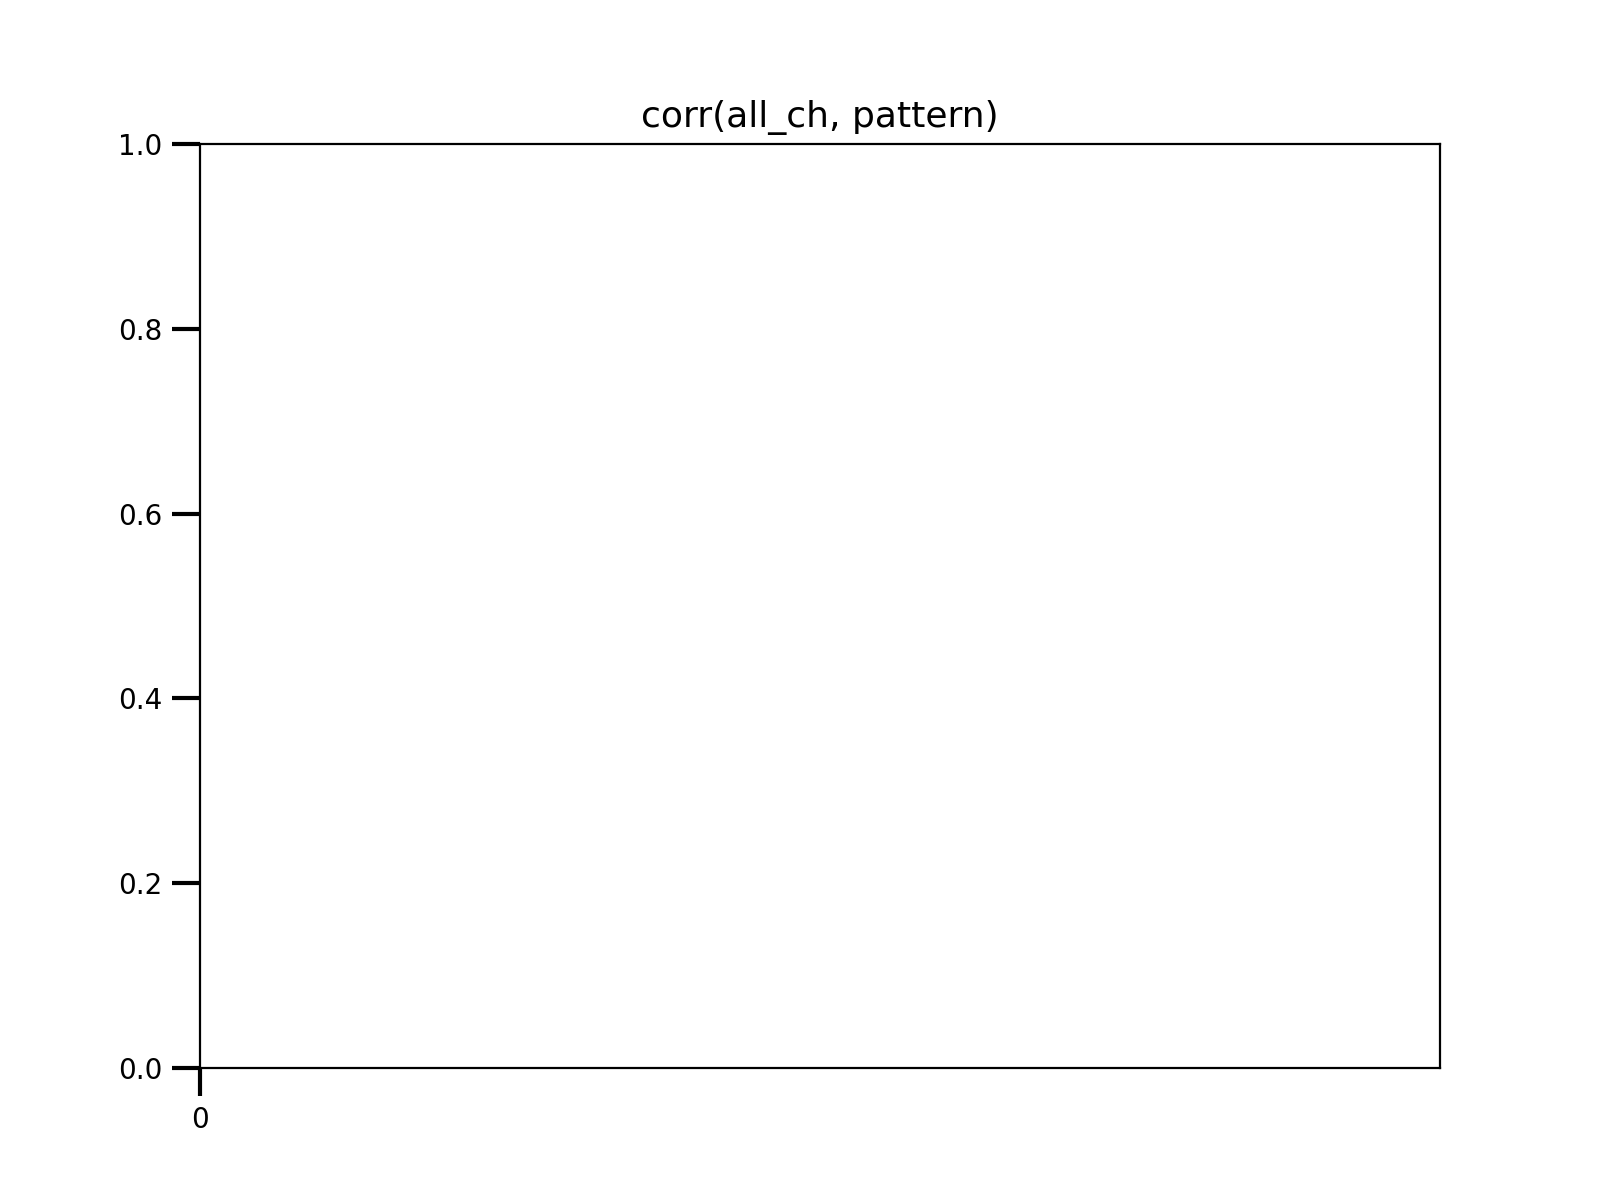

NameError: name 'corr_wdm' is not defined

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)

lines = []
for i in range(6):
    line1, = ax.plot(corr_wdm[i], lw=1.5, label = str(i) + ' channel')
    lines.append(line1)
    
    
leg = ax.legend(fancybox=True, shadow=True)
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()
    
plt.ylabel('amplitude (acp)', size=12);
plt.xlabel('time (points)', size=12);

fig.canvas.mpl_connect('pick_event', on_pick)

In [ ]:
summ = [0 for i in range(len(corr_wdm[0]))]

q = len(corr_wdm)
q2 = len(corr_wdm[i])

for i in range(q):
    for k in range(q2):
        summ[k] += corr_wdm[i][k]

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.tick_params(axis='both', which='major', labelsize=10, length = 10,    #  Длинна делений
           width = 1.5)
plt.plot(summ, 'r')
plt.ylabel('amplitude', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

In [ ]:
fbands = [round(float(head['fbands'][i]),2) for i in range(len(head['fbands']))]
fbands.reverse()
fig, ax = plt.subplots(figsize=(15, 2))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_dm,
                           cmap="Greys", yticklabels=False)
plt.show();

In [ ]:
corr_aver_dm = []
for i in range(6):
    b = normalize(corr_dm[i])
    #a = averaging(b, 1)
    corr_aver_dm.append(b)

fig, ax = plt.subplots(figsize=(15, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
x_labels = [i for i in range(0,len(corr_aver_dm[0]),100)]
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_aver_dm,
                           cmap="Greys", yticklabels=False)
plt.show();

In [ ]:
from scipy.ndimage.filters import gaussian_filter
corr_blur_dm = []
for i in range(len(corr_dm)):
    a = gaussian_filter(corr_dm[i], sigma=5)
    a = normalize(a)
    corr_blur_dm.append(a)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
x_labels = [i for i in range(0,len(corr_aver_dm[0]),100)]
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_blur_dm,
                           cmap="Greys", yticklabels=False)

plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
x_labels = [i for i in range(0,len(corr_aver_dm[0]),100)]
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_wdm,
                           cmap="Greys", yticklabels=False)

plt.show();

In [ ]:
corr_aver_wdm = []
for i in range(6):
    b = normalize(corr_wdm[i])
    #a = averaging(b, 1)
    corr_aver_wdm.append(b)

fig, ax = plt.subplots(figsize=(15, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
x_labels = [i for i in range(0,len(corr_aver_wdm[0]),100)]
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_aver_wdm,
                           cmap="Greys", yticklabels=fbands, cbar=False)
plt.show();

In [ ]:
from scipy.ndimage.filters import gaussian_filter
corr_blur_wdm = []
for i in range(len(corr_wdm)):
    a = gaussian_filter(corr_wdm[i], sigma=5)
    a = normalize(a)
    corr_blur_wdm.append(a)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xlabel('Время [мс]', fontsize=12)
sns.axes_style('whitegrid')
x_labels = [i for i in range(0,len(corr_aver_wdm[0]),100)]
plt.ylabel("Плотность потока [АЦП]", fontsize=12)
heatmap_plot = sns.heatmap(corr_blur_wdm,
                           cmap="Greys", yticklabels=fbands)

plt.show();

## Шаблоны импульса с учетом рассеяния в зависимости от DM по Кузьмину

In [ ]:
def scattering_kuz (DM):
    t_s = 60*(DM/100)**2.2
    return t_s

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            #a.append((1/t_s)*(np.exp(-x[i]/t_s)))
            a.append((np.exp(-x[i]/t_s)))
            
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

In [ ]:
t_s_list = []
dm_list = [i for i in range(3,2005)]
for i in range(len(dm_list)):
    DM = dm_list[i]
    t_s = scattering_kuz (DM)
    t_s_list.append(t_s)    
    print(DM, t_s)
    

In [ ]:
DM = 333
n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM*10**-3))) #в секундах 

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000)))) # в точках
        
t4 = [abs(i)*1000 for i in t]

In [ ]:
t4

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(dm_list, t_s_list)
ax.loglog()
plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.title('scattering_kuzmin', size=15)
ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.show();

In [ ]:
DM = 100
n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM*10**-3))) #в секундах 

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000)))) # в точках

In [ ]:
#fig, ax = plt.subplots(figsize=(8, 6))
#for k in range(9,len(dm_list),100):
for k in range(1764,1770,1):
    
    DM = dm_list[k]
    
    n, t, t2 = [], [], []
    for i in range(int(head['nbands'][0])):
        n.append((float((head['fbands'][i])[0:-1:]))**-2)

    for i in range(int(head['nbands'][0])):
        t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM*10**-3)))

    for i in range(int(head['nbands'][0])):
        if t[i] == 0:
            t2.append(0)
        else:
            t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000))))
            
            
    t2.sort()
    t3 = [abs(i) for i in t]
    t3.sort()
    print(t3)
            
    lenth = int(DM*20*i)
    x = [i for i in range(-1,int(lenth))]
                                                 
    fig, ax = plt.subplots(figsize=(8, 6))
    
    t_s = scattering_kuz (dm_list[k])
    #if t_s < 

    
    x_scatter = scatter(x,t_s,t2[1])
    
    norm = 1/max(x_scatter)
    for i in range (len((x_scatter))):
        x_scatter[i]*=norm
        
    time_plot = [i/1000 for i in range(len(x_scatter))]
    
    plt.plot(time_plot[:int(t_s*11.5)],x_scatter[:int(t_s*11.5)], 'r')
    #plt.plot(x_scatter, 'r')
    
    plt.title('pattern_kuz, DM = ' + str(dm_list[k]) + ', ' + '$\mathregular{τ_s}$ = ' + ' ' + str(round(t_s,2)) + ' ms', size=15)
    ax.tick_params(axis='both', which='major', labelsize=10, length = 5,    #  Длинна делений
               width = 1)
    
    plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
    plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
    matplotlib.rc('xtick', labelsize=15)
    matplotlib.rc('ytick', labelsize=15)
    ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
    plt.grid(True)
    
    plt.ylabel('amplitude(acp)', size=15)
    plt.xlabel('time (s)', size=15)
    plt.show();

## Шаблоны импульса с учетом рассеяния в зависимости от DM по Бхату

In [ ]:
def scattering_bhat (a, b, c, DM):
    t = a + (b*(math.log10(DM))) + c*(math.log10(DM)**2)# - (4.4*(math.log10(0.111)))   
    #t_s = a + b*(np.log(DM)) + c*(np.log(DM))**2
    t_s = pow(10, t)
    print(t_s)
    return t_s

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            a.append((1/t_s)*(np.exp(-x[i]/t_s)))
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

In [ ]:
t_s_list = []
dm_list = [i for i in range(3,2005)]

a, b, c = -6.46, 0.154, 1.07
a, b, c =  -6.59, 0.129, 1.02
for i in range(len(dm_list)):
    DM = dm_list[i]
    t = scattering_bhat (a, b, c, DM)
    t_s_list.append(t)    

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(dm_list, t_s_list)
ax.loglog()
plt.ylabel('t_s', size=15)
plt.xlabel('dm', size=15)
plt.title('scattering_bhat', size=15)
ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.show();

In [ ]:
#fig, ax = plt.subplots(figsize=(8, 6))
for k in range(97,len(dm_list),100):

    DM = dm_list[k]
    
    n, t, t2 = [], [], []
    for i in range(int(head['nbands'][0])):
        n.append((float((head['fbands'][i])[0:-1:]))**-2)

    for i in range(int(head['nbands'][0])):
        t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM)))

    for i in range(int(head['nbands'][0])):
        if t[i] == 0:
            t2.append(0)
        else:
            t2.append(abs(round(t[i] / (float(head['tresolution'][0])/1000))))
            
            
    t2.sort()
    
            
    lenth = int(DM*200*i)
    x = [i for i in range(-1,int(lenth))]
                                                 
    fig, ax = plt.subplots(figsize=(8, 6))
    
    t_s = scattering_bhat (a,b,c,dm_list[k])
    x_scatter = scatter(x,t_s,t2[1])
    
    norm = 1/max(x_scatter)
    for i in range (len((x_scatter))):
        x_scatter[i]*=norm
        
    time_plot = [i/10 for i in range(len(x_scatter))]
    print(DM, t_s, len(time_plot))
    
    if int(round(t_s)*11.5) > 1:
        plt.plot(time_plot[:int(round(t_s)*11.5)],x_scatter[:int(round(t_s)*11.5)], 'r')
        
    else:
        plt.plot(time_plot[:10],x_scatter[:10], 'r')
        
    #plt.plot(x_scatter, 'r')
    
    plt.title('pattern_bhat, DM = ' + str(dm_list[k]) + ', ' + '$\mathregular{τ_s}$ = ' + ' ' + str(round(t_s,2)) + ' ms', size=15)
    ax.tick_params(axis='both', which='major', labelsize=10, length = 5,    #  Длинна делений
               width = 1)
    
    plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
    plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
    matplotlib.rc('xtick', labelsize=15)
    matplotlib.rc('ytick', labelsize=15)
    ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
    plt.grid(True)
    
    plt.ylabel('amplitude(acp)', size=15)
    plt.xlabel('time (ms)', size=15)
    plt.show();

In [ ]:
numbers_freq = {'Apertif': (1370, 1), 'Arecibo': (1440, 2), 'ASCAP': (1297, 31), 'CHIME': (600, 29), 'UTMOST': (
    843, 8), 'Parkes': (1351, 27), 'FAST': (1750, 1), 'GBT': (1440, 1), 'VLA': (1440, 1), 'DSA-10': (1440, 1)}

In [ ]:
numbers_freq

In [123]:
#frequency_all = [i for i in range(1000, 2000, 10)]
frequency_all = [600, 843, 1297, 1351,1370, 1440, 1750]
number_all = [29, 8, 31, 27, 1, 5, 1]

<IPython.core.display.Javascript object>


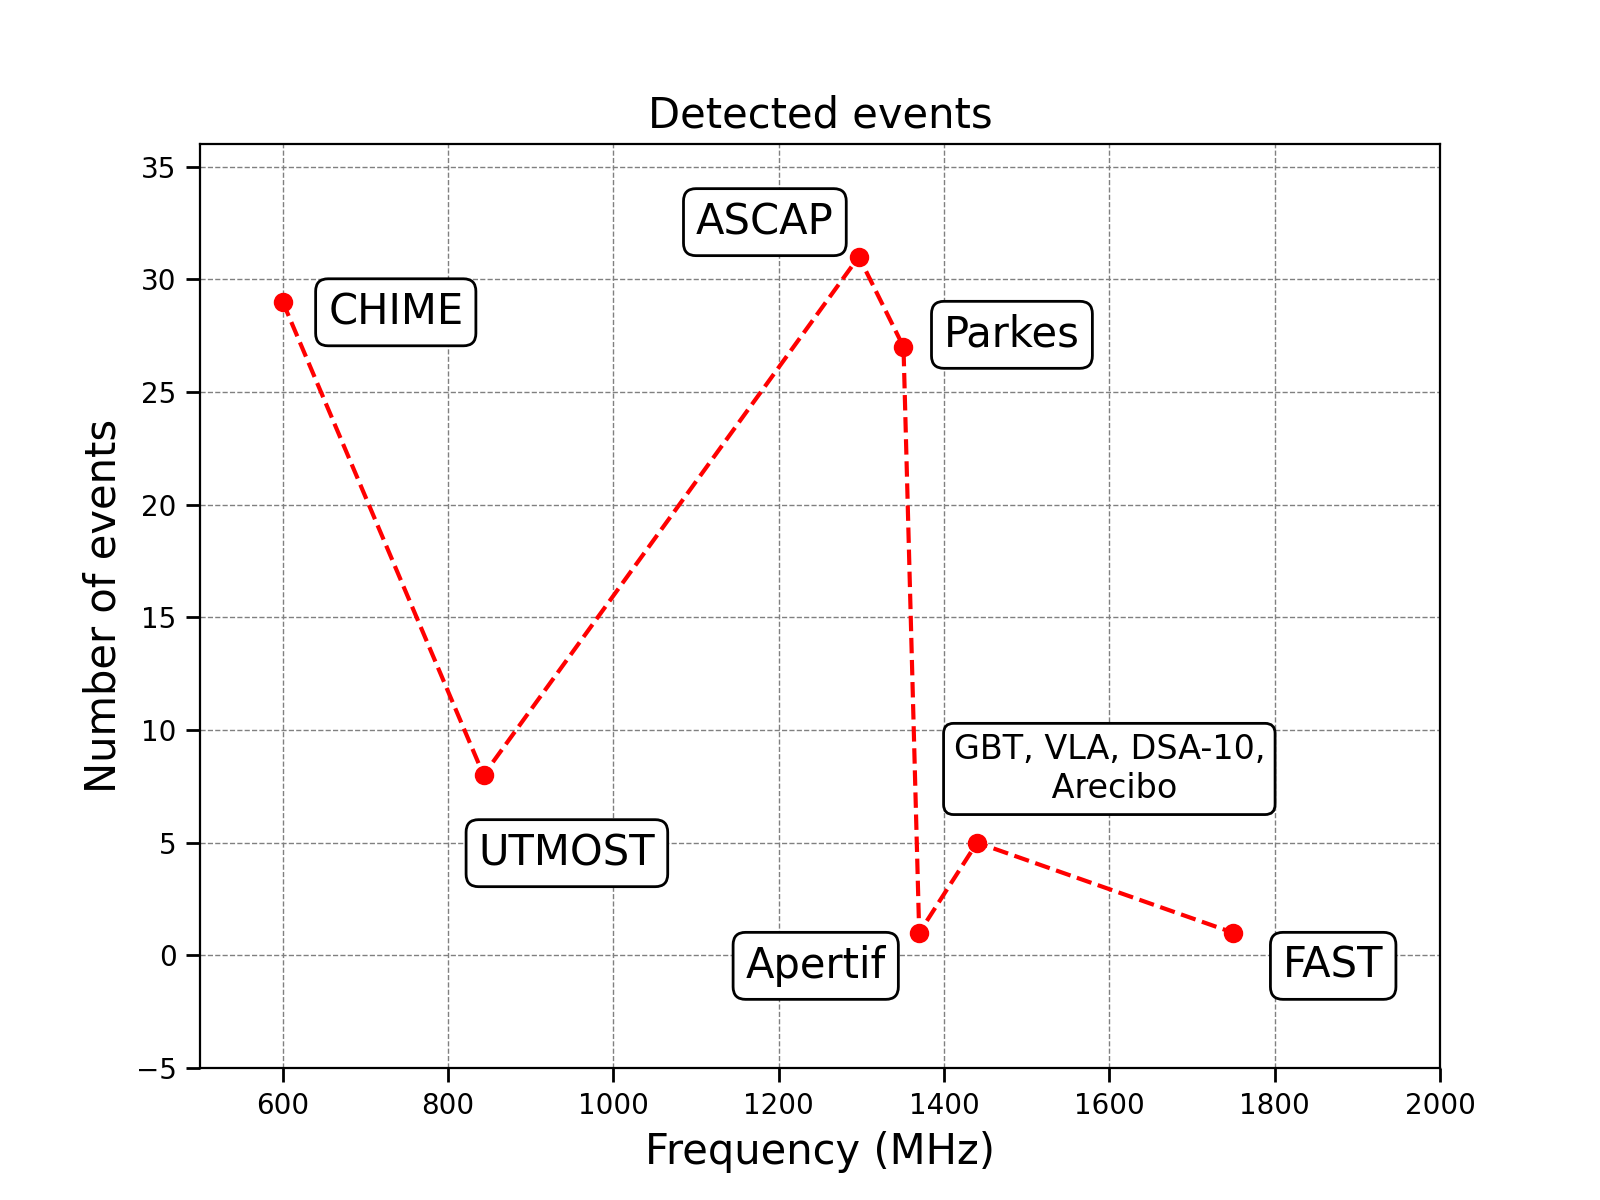

In [124]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Detected events', size=15)
ax.tick_params(axis='both', which='major', labelsize=10, length = 5,    #  Длинна делений
           width = 1)

plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.plot(frequency_all, number_all, 'ro--')

plt.ylabel('Number of events', size=15)
plt.xlabel('Frequency (MHz)', size=15)

box_1 = {'facecolor':'white',    #  цвет области
       'edgecolor': 'black',     #  цвет крайней линии
       'boxstyle': 'round'} 

ax.text(655, 28, 'CHIME',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(837, 4, 'UTMOST',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1100, 32, 'ASCAP',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1400, 27, 'Parkes',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1160, -1, 'Apertif',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1600, 7, 'GBT, VLA, DSA-10,\n Arecibo',
        bbox = box_1,
        horizontalalignment = 'center',
        color = 'black',    #  цвет шрифта
        fontsize = 12)

ax.text(1810, -1, 'FAST',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)


ax.axis([500, 2000, -5, 36])
plt.show();